In [1]:
import io
from collections import namedtuple
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline
import matplotlib.pyplot as plt
import json
from google.protobuf.json_format import MessageToJson
from google.protobuf.json_format import Parse
from google.protobuf import json_format
import os
import sys
sys.path.append("..")
from models.bounding_box import FeatureType, Point, BoundingBox, DSU
from utils.cv_preprocess import draw_boxes, group_bounding_boxes, merge_box_groups

from utils.file_utils import prepare_image_local, prepare_image_web, load_counter, save_counter, save_json

from utils.nlp_preprocess import load_spacy_models, is_english, is_chinese, split_dish_info, is_word_relevant
from models.word_unit import WordUnit
from models.dish_segmenter import Dish
from IPython.display import display



f:\Anaconda\envs\Translation\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_spacy_models()

In [3]:
filein = '../downloads/Ma-La-Menu_07-2023.pdf'
base_name = os.path.basename(filein)
file_name_without_extension = os.path.splitext(base_name)[0]


raw_ocr_directory = '../output/raw_ocr/'
raw_ocr_filename = file_name_without_extension + "_raw_annotation.json"
raw_ocr_path = os.path.join(raw_ocr_directory, raw_ocr_filename)

preprocessed_ocr_directory = '../output/prep_ocr/'
preprocessed_ocr_filename = file_name_without_extension + "_prep_ocr.json"
preprocessed_ocr_path = os.path.join(preprocessed_ocr_directory, preprocessed_ocr_filename)

In [4]:
# Open the file for reading
with open(raw_ocr_path, 'r') as file:
    document = json.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '../output/raw_ocr/Ma-La-Menu_07-2023_raw_annotation.json'

In [31]:
image = Image.open(filein)

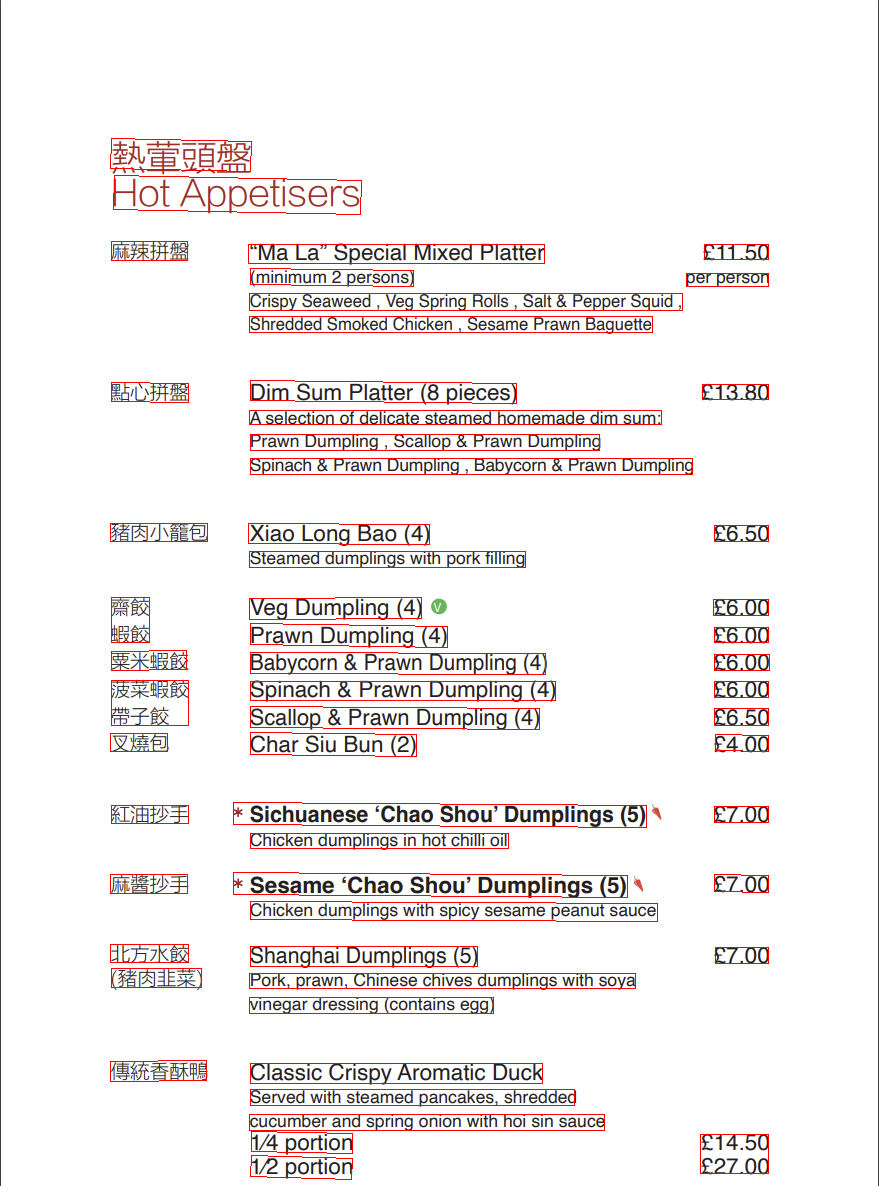

In [32]:
image = Image.open(filein)

feature = FeatureType.PARA

bounds = []

# Collect specified feature bounds by enumerating all document features

paragraph_bounds = []
for page in document['pages']:
    for block in page['blocks']:
        paragraph_word = []
        for paragraph in block['paragraphs']:
            words = []
            for word in paragraph['words']:

                
                symbols_data = [(symbol['text'], symbol['confidence']) for symbol in word['symbols'] if symbol['confidence'] > 0.8]

                # Extracting the text and confidence values
                symbols_text = ''.join([data[0] for data in symbols_data])
                average_confidence = sum([data[1] for data in symbols_data]) / len(symbols_data) if symbols_data else 0

                words.append(WordUnit(symbols_text, average_confidence))   
            
            # paragraph_bounds.append(BoundingBox(paragraph['boundingBox']['vertices'], words))
            paragraph_word.extend(words)
        
            if feature == FeatureType.PARA:
                bounds.append(BoundingBox(paragraph['boundingBox']['vertices'], words))

        if feature == FeatureType.BLOCK:
            bounds.append(BoundingBox(block['boundingBox']['vertices'], paragraph_word))

draw_boxes(image, bounds, "red")
# plt.figure(figsize=(10, 10))
display(image)

In [33]:
grouped_bounds = group_bounding_boxes(bounds)
merged_boxes = merge_box_groups(grouped_bounds)

In [34]:
bounds[2].is_close_enough(bounds[3])

False

In [35]:
bounds[2].vertices

[{'x': 111, 'y': 241},
 {'x': 187, 'y': 241},
 {'x': 187, 'y': 260},
 {'x': 111, 'y': 260}]

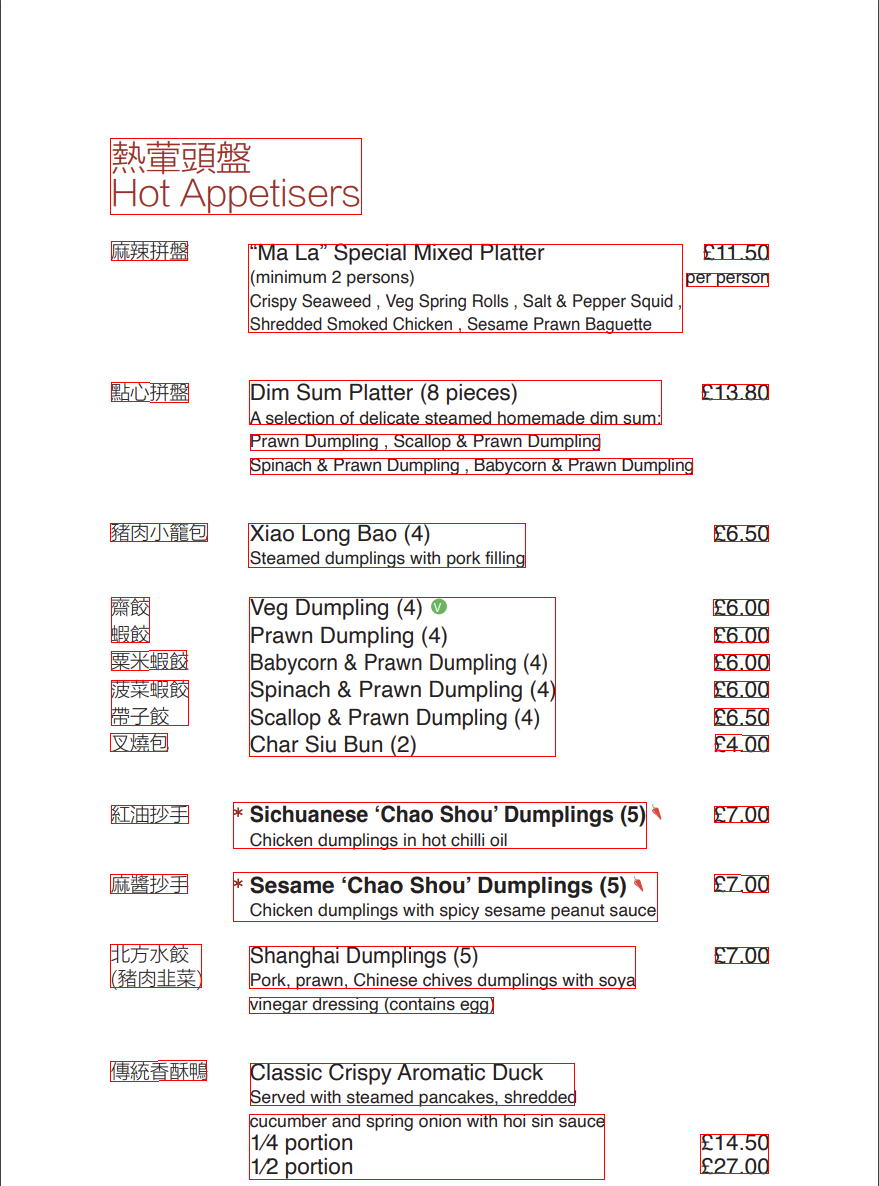

In [36]:
image_after = Image.open(filein)
draw_boxes(image_after, merged_boxes, "red")
display(image_after)

In [37]:
dish_instance_list = []
for box in merged_boxes:
    dish = split_dish_info(box.text)
    dish_instance_list.append(dish)

In [38]:
print(dish_instance_list[0])

Chinese Name: [葷]
English Name: [Appetisers]
Chinese Description: []
English Description: []
Raw text: [熱, 葷, 頭, 盤, Hot, Appetisers]



In [39]:
results = [obj.to_dict() for obj in dish_instance_list]
save_json(results, preprocessed_ocr_path)